In [13]:
# =========================
# Core libraries
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

# =========================
# Sklearn / Imbalanced-learn
# =========================
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# =========================
# Utilities
# =========================
from IPython.display import Markdown, display

# =========================
# Reproducibility
# =========================
SEED = 0
np.random.seed(SEED)

In [14]:
# =========================
# Load dataset splits
# =========================
DATA_PATH = "../../Datasets/Norway Dataset Splits"

X_train = pd.read_csv(f"{DATA_PATH}/X_train.csv")
X_test  = pd.read_csv(f"{DATA_PATH}/X_test.csv")
Y_train = pd.read_csv(f"{DATA_PATH}/Y_train.csv")
Y_test  = pd.read_csv(f"{DATA_PATH}/Y_test.csv")

# Ensure y is 1D
y_train = np.ravel(Y_train)
y_test  = np.ravel(Y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((209, 20789), (52, 20789), (209,), (52,))

In [15]:
# =========================
# RFE + RS Pipeline
# =========================

display(Markdown("# RFE + Randomized Search"))

# =========================
# Pipeline with RFE
# =========================
pipeline_rfe = ImbPipeline([
    ("scaler", StandardScaler()),
    ("rfe", RFE(
        estimator=RandomForestClassifier(random_state=SEED)
    )),
    ("smote", SMOTE(random_state=SEED)),
    ("rf", RandomForestClassifier(random_state=SEED))
])

# =========================
# Parameter distributions
# =========================
param_dist_rfe = {
    'rfe__step': [0.25],
    'rfe__n_features_to_select': [500],

    'smote__k_neighbors': [3, 5],
    
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': [None] + list(range(5, 31, 5)),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 5),
}

# (ranges before the best was found)
# 'rf__n_estimators': randint(50, 300),
# 'rf__max_depth': [None] + list(range(5, 31, 5)),
# 'rf__max_features': ['sqrt', 'log2'],
# 'rf__min_samples_split': randint(2, 10),
# 'rf__min_samples_leaf': randint(1, 5),

# RFE + Randomized Search

In [16]:
# =========================
# Training RFE + RS Model
# =========================

random_search_rfe = RandomizedSearchCV(
    pipeline_rfe,
    param_distributions=param_dist_rfe,
    n_iter=50,
    cv=3,
    scoring="f1_weighted",
    random_state=SEED,
    n_jobs=-1,
    verbose=2
)

random_search_rfe.fit(X_train, y_train)

best_model_rfe = random_search_rfe.best_estimator_

print("Best parameters:")
print(random_search_rfe.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters:
{'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 293, 'rfe__n_features_to_select': 500, 'rfe__step': 0.25, 'smote__k_neighbors': 5}


Accuracy: 0.7115384615384616
              precision    recall  f1-score   support

       Basal       0.88      1.00      0.93         7
        Her2       0.56      0.71      0.62         7
        LumA       0.81      0.74      0.77        23
        LumB       0.57      0.67      0.62        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.71        52
   macro avg       0.56      0.62      0.59        52
weighted avg       0.68      0.71      0.69        52



c:\Users\Roooiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roooiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roooiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


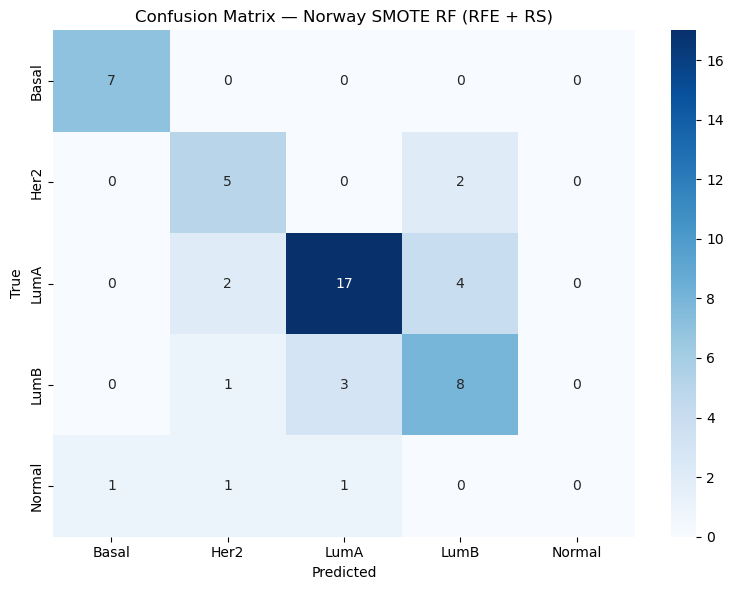

In [17]:
# =========================
# RFE + RS Model Evaluation
# =========================

y_pred_rfe = best_model_rfe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))

cm = confusion_matrix(y_test, y_pred_rfe)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Norway SMOTE RF (RFE + RS)")
plt.tight_layout()
plt.show()

C:\Users\Roooiz\AppData\Local\Temp\ipykernel_14900\862065632.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


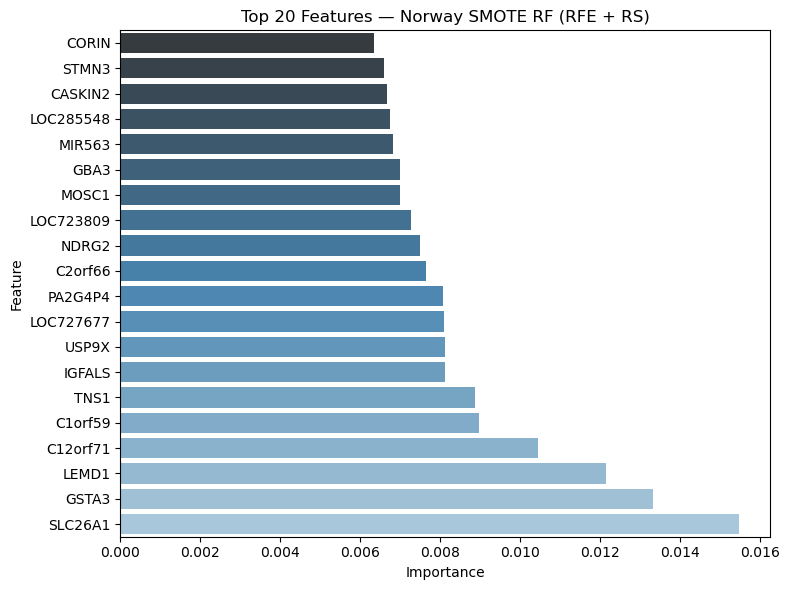

In [18]:
# =========================
# Model Feature Importance
# =========================

rfe = best_model_rfe.named_steps["rfe"]
rf_inner = rfe.estimator_

selected_mask = rfe.support_
selected_features = X_train.columns[selected_mask]

importances = rf_inner.feature_importances_

rfe_importances = (
    pd.DataFrame({
        "Feature": selected_features,
        "Importance": importances
    })
    .sort_values("Importance", ascending=False)
)

top_20_rfe = rfe_importances.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_20_rfe,
    x="Importance",
    y="Feature",
    palette="Blues_d"
)
plt.gca().invert_yaxis()
plt.title("Top 20 Features — Norway SMOTE RF (RFE + RS)")
plt.tight_layout()
plt.show()

In [19]:
# =========================
# RS Pipeline
# =========================

display(Markdown("# Random Search (No RFE)"))

pipeline_no_rfe = ImbPipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=SEED)),
    ("rf", RandomForestClassifier(random_state=SEED))
])

param_dist_no_rfe = {
    'smote__k_neighbors': [3, 5],
    
    'rf__n_estimators': randint(50, 300),
    'rf__max_depth': [None] + list(range(5, 31, 5)),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__min_samples_split': randint(2, 10),
    'rf__min_samples_leaf': randint(1, 5),
}

# (ranges before the best was found)
# 'rf__n_estimators': randint(50, 300)
# 'rf__max_depth': [None] + list(range(5, 31, 5))
# 'rf__max_features': ['sqrt', 'log2']
# 'rf__min_samples_split': randint(2, 10)
# 'rf__min_samples_leaf': randint(1, 5)

# Random Search (No RFE)

In [20]:
# =========================
# Training RS Model
# =========================

random_search_no_rfe = RandomizedSearchCV(
    pipeline_no_rfe,
    param_distributions=param_dist_no_rfe,
    n_iter=50,
    cv=3,
    scoring="f1_weighted",
    random_state=SEED,
    n_jobs=-1,
    verbose=2
)

random_search_no_rfe.fit(X_train, y_train)

best_model_no_rfe = random_search_no_rfe.best_estimator_

print("Best parameters:")
print(random_search_no_rfe.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters:
{'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 272, 'smote__k_neighbors': 5}


Accuracy: 0.7115384615384616
              precision    recall  f1-score   support

       Basal       0.88      1.00      0.93         7
        Her2       0.43      0.43      0.43         7
        LumA       0.71      0.87      0.78        23
        LumB       0.78      0.58      0.67        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.71        52
   macro avg       0.56      0.58      0.56        52
weighted avg       0.67      0.71      0.68        52



c:\Users\Roooiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roooiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Roooiz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


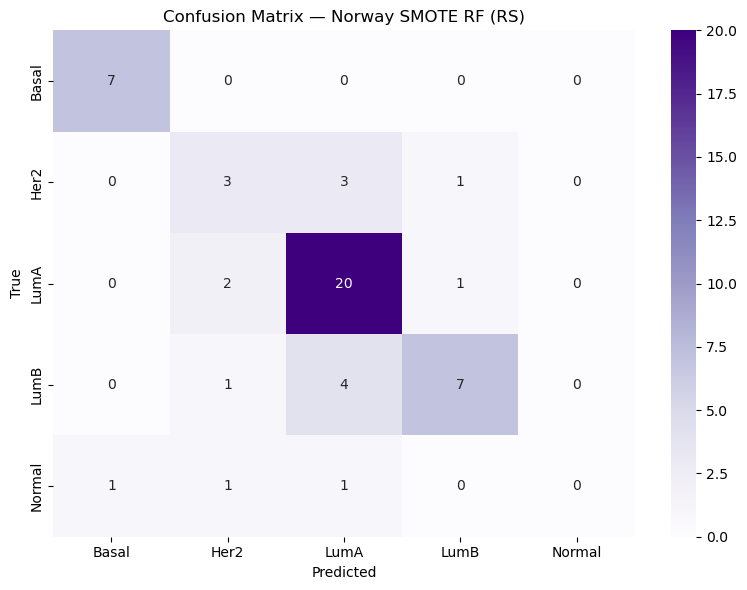

In [21]:
# =========================
# RS Model Evaluation
# =========================

y_pred_no_rfe = best_model_no_rfe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_no_rfe))
print(classification_report(y_test, y_pred_no_rfe))

cm = confusion_matrix(y_test, y_pred_no_rfe)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Purples",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Norway SMOTE RF (RS)")
plt.tight_layout()
plt.show()

C:\Users\Roooiz\AppData\Local\Temp\ipykernel_14900\2466188728.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


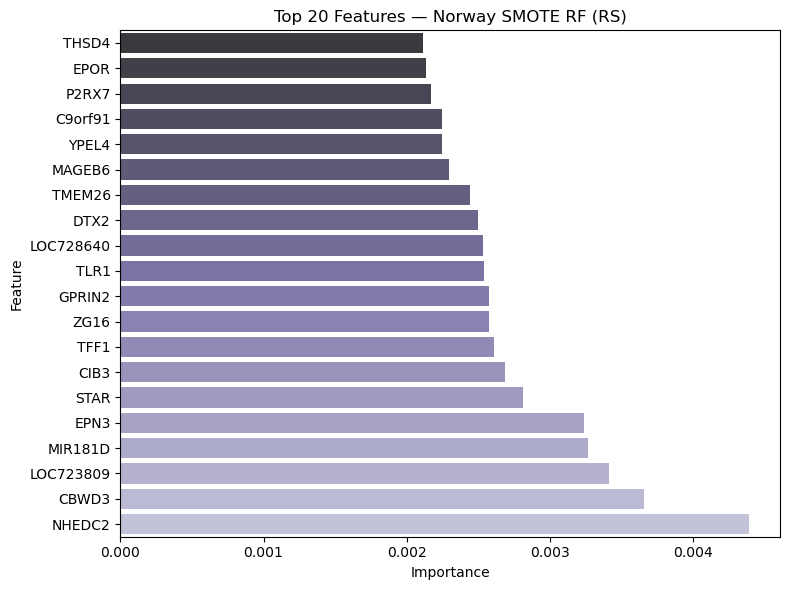

In [22]:
# =========================
# Model Feature Importance
# =========================

rf_model = best_model_no_rfe.named_steps["rf"]

feat_imp = (
    pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": rf_model.feature_importances_
    })
    .sort_values("Importance", ascending=False)
)

top_20_no_rfe = feat_imp.head(20)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_20_no_rfe,
    x="Importance",
    y="Feature",
    palette="Purples_d"
)
plt.gca().invert_yaxis()
plt.title("Top 20 Features — Norway SMOTE RF (RS)")
plt.tight_layout()
plt.show()

Norway SMOTE RF Random Search + RFE — Macro AUC-PR = 0.670


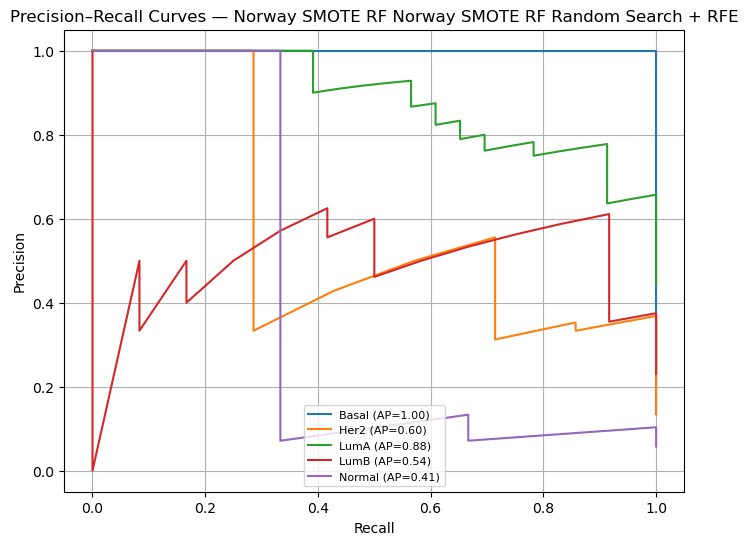

Norway SMOTE RF Random Search — Macro AUC-PR = 0.659


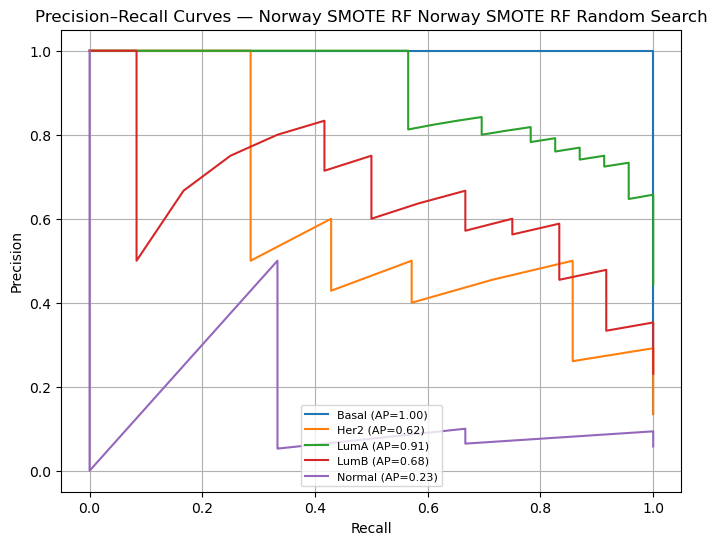

In [23]:
# =========================
# Precision–Recall Curves
# =========================

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

models = {
    "Norway SMOTE RF Random Search + RFE": best_model_rfe,
    "Norway SMOTE RF Random Search": best_model_no_rfe,
}

for name, model in models.items():
    plt.figure(figsize=(8, 6))

    y_score = model.predict_proba(X_test)
    aucs = []

    for i, cls in enumerate(classes):
        p, r, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
        aucs.append(auc(r, p))

        plt.plot(r, p, label=f"{cls} (AP={ap:.2f})")

    print(f"{name} — Macro AUC-PR = {np.mean(aucs):.3f}")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curves — Norway SMOTE RF {name}")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.show()

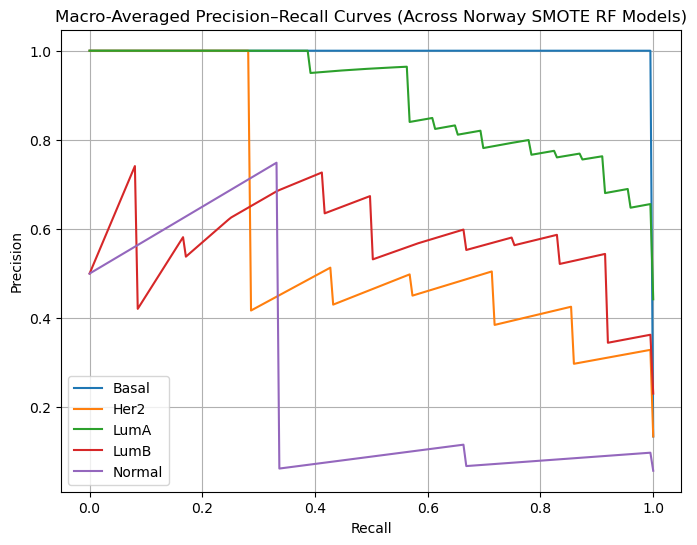

In [24]:
# =========================
# Macro-Averaged PR Curves
# =========================

plt.figure(figsize=(8, 6))
recall_grid = np.linspace(0, 1, 200)

for i, cls in enumerate(classes):
    precisions = []

    for model in models.values():
        y_score = model.predict_proba(X_test)
        p, r, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        precisions.append(np.interp(recall_grid, r[::-1], p[::-1]))

    mean_precision = np.mean(precisions, axis=0)
    plt.plot(recall_grid, mean_precision, label=cls)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Macro-Averaged Precision–Recall Curves (Across Norway SMOTE RF Models)")
plt.legend()
plt.grid(True)
plt.show()